In [1]:
# Author: Jenny Qin

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [6]:
print(norm.cdf(0.15*0.75))
print(norm.cdf(0.15*0.5))
print(norm.cdf(0.15*0.25))

0.544786515128255
0.5298926440528947
0.5149568299259097


1. a) Simulate daily ($ \delta_t = 1/252 $) stock price moveemnt 10,000 times, and compute, for each path, the cumulative difference/hedging error. Then average the absolute difference across 10,000 simulated paths and examine the distribution of the hedging error. What if you rebalance once a week? You should redo the exercise assuming weekly rebalance (you would need to simulate weekly ( $ \delta_t = 1/52 $))

In [18]:
# compute N(d1) and Ke^r(T-t)N(d2)
def compute_port0(s,K,t,r,vol,T):
    '''
        This function compute the theoretical delta and borrowed money amount at time 0. 
    '''
    d1 = (np.log(s/K)+(r+0.5*vol**2)*(T-t))/(vol*np.sqrt(T-t))
    d2 = d1 - vol*np.sqrt(T-t)

    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    stock_shares = norm.cdf(d1)
    borrowed_amount = K*np.exp(r*(T-t))*N_d2
    return stock_shares, borrowed_amount


In [19]:
def compute_nd1(s,K,t,T,r,vol):
    '''
        This function computes nd1 for daily rebalanced portfolio
        s: stock value at time t
        t: time period t
        T: total time period 
        K: strike price for this option
        r: risk free interest rate
        vol: annualized volatility
    '''
    d1 = (np.log(s/K)+(r+0.5*vol**2)*(T-t))/(vol*np.sqrt(T-t))
    N_d1 = norm.cdf(d1)
    return N_d1

In [20]:
def compute_borrowed(delta_now, delta_before, borrowed_before, s_before, s_now, r, delta_t):
    port_from_before = delta_before * s_now - borrowed_before * np.exp(r*delta_t)
    port_in_stock = delta_now * s_now
    borrowed = port_in_stock - port_from_before
    return borrowed

In [21]:
# set values to r and $\sigma$
r = 0.02 #2%
vol = 0.4 #40
N = 252 #252
dt = 1/N
s0 = 100
K = 100
T = 1

# get simulated stock values for 10,000 paths
stock_values = np.zeros((10000,N+1))
stock_values[:,0] = s0

for t in range(1,stock_values.shape[1]):
    brownian=np.random.standard_normal(stock_values.shape[0])
    stock_values[:,t]=(stock_values[:,t-1]*np.exp((r-vol**2/2.)*dt+vol*brownian*np.sqrt(dt)))

# compute theoretical borrowed money and shares of stocks purchased at T
stock_shares, borrowed = compute_port0(s0,100,0,r,vol,T)
print("At time zero, we need to purchase {:.3f} shares".format(stock_shares)) # figure out how to print decimal numbers in specific format
print("At time zero, we need to borrow {:.2f} amount of money".format(borrowed))

# Compute portfolio value for all 10,000 paths at T
portT = stock_shares*stock_values[:,N] - borrowed*np.exp(r*T)


At time zero, we need to purchase 0.599 shares
At time zero, we need to borrow 44.93 amount of money


A synthetic portfolio for European call option ($\sigma$ = 40) at time 0 is to purchase 0.599 stocks and borrow $44.93 in bond.

In [22]:
# compute number of stock shares for t = 0,1,...251, rebalanced daily
nd1_matrix = np.zeros((10000,N))
for t in range(N):
        nd1_matrix[:,t] = compute_nd1(stock_values[:,t],K,t*dt,T,r,vol)

In [23]:
borrowed_matrix = np.zeros((10000,N))
borrowed_matrix[:,0] = borrowed
for t in range(1, N):
        borrowed_matrix[:,t] = compute_borrowed(nd1_matrix[:,t], nd1_matrix[:,t-1], borrowed_matrix[:,t-1], stock_values[:,t-1], stock_values[:,t], r, dt)

In [24]:
# compute portfolio value at time T and calculate hedging error

rebalaced_portT = nd1_matrix[:,N-1] * stock_values[:,N] - borrowed_matrix[:,N-1]*np.exp(r*dt)
abs_diff = np.abs(portT - rebalaced_portT)
print("The average absolute hedging error for daily balanced portfolio is equal to {}".format(np.average(abs_diff)))


The average absolute hedging error for daily balanced portfolio is equal to 9.364823377274782


Text(0.5, 1.0, 'Distribution of hedging error at time = T for daily rebalance')

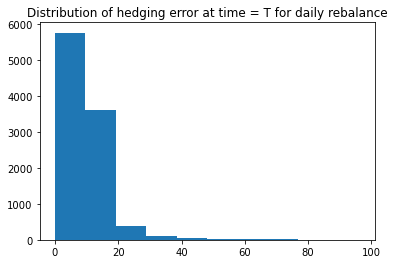

In [25]:
plt.hist(abs_diff)
plt.title("Distribution of hedging error at time = T for weekly rebalance")

Text(0.5, 1.0, 'Distribution of hedging error at time = T for daily rebalance')

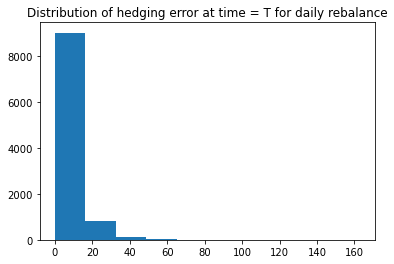

In [16]:
plt.hist(abs_diff)
plt.title("Distribution of hedging error at time = T for daily rebalance")

The average absolute hedging error for daily balanced portfolio is equal to 9.47 ($\sigma$ = 40%). And the hedging error for weekly balanced portfolio is $9.36.

 b) Assume a 1bp one way transaction cost for trading the underlying. 
At time t. need to buy or sell $ N(d1)_{t} - N(d1)_{t-1} $ amount of shares. 

In [26]:
# Compute transaction cost
def compute_cost(delta_now, delta_before, s_now, bp=0.0001):
    diff = np.abs(delta_now - delta_before)
    total_transaction = np.abs(delta_now - delta_before)*s_now 
    transaction_cost = total_transaction * bp
    return transaction_cost

In [27]:
cost_matrix = np.zeros((10000, N))
for t in range(N):
        if t == 0:
            cost_matrix[:,t] = nd1_matrix[:,t] * stock_values[:,t] * 0.0001
        else:
            cost_matrix[:,t] = compute_cost(nd1_matrix[:,t],nd1_matrix[:,t-1], stock_values[:,t])

Accumulated_cost = np.zeros(10000)
for i in range(10000):
    for t in range(N):
        Accumulated_cost[i] += cost_matrix[i,t] * (np.exp(r*(N-t)/N))
np.average(Accumulated_cost )


0.028644001177711296

Average transaction cost for daily rebalance is 0.056. And for weekly rebalance is 0.0286.

c) If you are the market maker, how much would you charge for this call option in light of the discrepancy in hedging error and transaction cost

When $\sigma$ is estimated to be 40%, the average hedging error at time T is 9.47. And the average transaction cost would be 0.056. Therefore, I would charge $9.526 in light of these discrepancy. 

d) What if you misestimated the underlying stock's volatility? What would be the
hedged gain or loss if the underlying volatility is 50% or 30%? Please compute
for each case.

2. (a) Simulate daily stock price movement and use the simulation to price 1-year Eu-
ropean call options with S0 = 100 and K from 75 to 125 with $5 increments. The
initial instantaneous variance is assumed to be equal to its long run mean.

In [3]:
import numpy as np
from scipy.stats import norm

In [65]:
def heston_price(s0, K, r, kappa, theta, eta, rho, dt, N, T):
    t_steps = int(1/dt)
    s = np.zeros((N, t_steps+1))
    s[:,0] = s0
    v = np.zeros((N,t_steps+1))
    v[:,0] = theta # theta = 0.04
    
    x1 = np.zeros((N,t_steps+1))
    x2 = np.zeros((N,t_steps+1))
    for t in range(1, t_steps+1):
        dx1 = np.random.normal(0, np.sqrt(dt), N)
        dx2 = np.random.normal(0, np.sqrt(dt), N)
        dws = dx1
        dwv = rho * dx1 + np.sqrt(1 - rho**2)*dx2
        
        dv = kappa*(theta-v[:,t-1])*dt + eta * np.sqrt(v[:,t-1])*dwv
        v[:,t] = v[:,t-1] + dv
        
        ds = s[:,t-1] * (r*dt + np.sqrt(v[:,t])*dws)
        
        s[:,t]=s[:,t-1] + ds
    
    print(v)
    payoffT = np.zeros(N)
    for j in range(N):
        payoffT[j] = max(0,s[j,t_steps]-K)
    price = np.average(np.exp(r*(T))*payoffT)
    return price

In [59]:
s0 = 100
K = 100
r = 0.02
kappa = 0.1
theta = 0.04
eta = 0.5
rho = -0.6
dt = 1/252
N = 10000



# compute black schole price for S0 = 100, K ranges from 75 to 125 with a step equals to $5
t = 0
T = 1
sigma = np.sqrt(theta)
d1 = (np.log(s0/K)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
N_d1 = norm.cdf(d1)
d2 = d1 - sigma*np.sqrt(T - t)
N_d2 = norm.cdf(d2)

prices = []
hestons = []
for K in range(75,125,5):
    price = s0*N_d1 - np.exp(-r*(T-t))*K*N_d2
    heston = heston_price(s0, K, r, kappa, theta, eta, rho, dt, N, T)
    prices.append(price)
    hestons.append(heston)
    print("BS European call price is {:.2f} when strike equals to {}".format(price, K))
    print("Heston European call price is {:.2f} when strike equals to {}".format(heston, K))

<ipython-input-55-ea738f18567c>:19: RuntimeWarning: invalid value encountered in sqrt
  ds = s[:,t-1] * (r*dt + np.sqrt(v[:,t])*dws)
<ipython-input-55-ea738f18567c>:16: RuntimeWarning: invalid value encountered in sqrt
  dv = kappa*(theta-v[:,t-1])*dt + eta * np.sqrt(v[:,t-1])*dwv


BS European call price is 21.17 when strike equals to 75
Heston European call price is 2.93 when strike equals to 75
BS European call price is 18.72 when strike equals to 80
Heston European call price is 2.26 when strike equals to 80
BS European call price is 16.27 when strike equals to 85
Heston European call price is 1.58 when strike equals to 85
BS European call price is 13.82 when strike equals to 90
Heston European call price is 1.16 when strike equals to 90
BS European call price is 11.37 when strike equals to 95
Heston European call price is 0.83 when strike equals to 95
BS European call price is 8.92 when strike equals to 100
Heston European call price is 0.55 when strike equals to 100
BS European call price is 6.47 when strike equals to 105
Heston European call price is 0.44 when strike equals to 105
BS European call price is 4.02 when strike equals to 110
Heston European call price is 0.30 when strike equals to 110
BS European call price is 1.56 when strike equals to 115
Hest